## 1. Challenge Dataset

In [37]:
rows_standard   = 200
cols_standard   = 200

### Utrecht and Singapore

In [38]:
singapore_path  = '/home/msc2/Documents/Data/WMH_Challenge/public/Singapore/Singapore/'
utrecht_path    = '/home/msc2/Documents/Data/WMH_Challenge/public/Utrecht/Utrecht/'

In [39]:
import nibabel as nib
import os
import scipy
import numpy as np
from tqdm import tqdm

def utrecht_preprocess(folder_path, 
                       output_path='/home/msc2/DATA/Slices', 
                       naming='challenge',
                       range_=(6,6),
                       valid_split=[]
                      ):
    # load the nii files
    full_t1_path    = os.path.join(folder_path, "pre", "T1.nii")
    full_flair_path = os.path.join(folder_path, "pre", "FLAIR.nii")
    full_mask_path  = os.path.join(folder_path, "wmh.nii")
    file_name       = folder_path.split('/')[-1]
    
    # rotate the axial slices such that the eyes face up
    t1    = np.rot90(nib.load(full_t1_path).get_fdata(),    k=3)
    flair = np.rot90(nib.load(full_flair_path).get_fdata(), k=3)
    mask  = np.rot90(nib.load(full_mask_path).get_fdata(),  k=3)
    
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows   = np.shape(flair)[0]
    cols   = np.shape(flair)[1]
    
    flair            =            flair[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]

    
    flair -= np.mean(flair)
    flair /=  np.std(flair)

    t1            =            t1[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    t1 -= np.mean(t1)
    t1 /=  np.std(t1)

    mask   =  mask[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    t1     =    t1[..., np.newaxis]
    flair  = flair[..., np.newaxis]
    mask   =  mask[..., np.newaxis]
    
    if len(np.unique(mask)) > 2:
        mask[mask == 2] = 0

    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid_normal')
    else:
        output_path = os.path.join(output_path, 'train_normal')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        np.save(f'{out_file_path}_t1.npy',       t1[:,:,i])
        np.save(f'{out_file_path}_flair.npy', flair[:,:,i])
        np.save(f'{out_file_path}_mask.npy',   mask[:,:,i])

In [40]:
import random
import os
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(singapore_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['58', '54', '63', '57']


In [41]:
for case in tqdm(os.listdir(singapore_path), 'Cases : '):
    folder_path = os.path.join(singapore_path, case)
    utrecht_preprocess(folder_path, naming='sing', valid_split=samples)

Cases : 100%|███████████████████████████████████| 20/20 [00:05<00:00,  3.70it/s]


-0.738877619321072 4.108522214163814
[0. 1.]


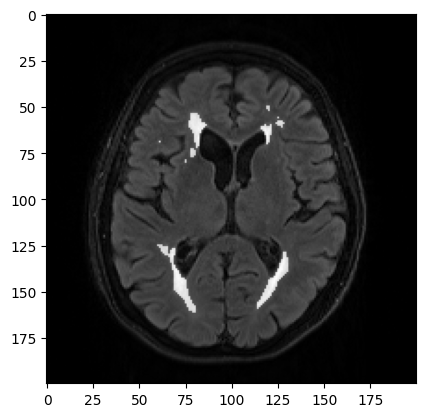

In [42]:
image = np.load('/home/msc2/DATA/Slices/train_normal/sing_050_IMG0025_flair.npy')
mask = np.load('/home/msc2/DATA/Slices/train_normal/sing_050_IMG0025_mask.npy')
print(np.min(image), np.max(image))
print(np.unique(mask))
import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.5)

In [43]:
import random
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(utrecht_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['39', '19', '8', '31']


In [44]:
for case in tqdm(os.listdir(utrecht_path), 'Cases : '):
    folder_path = os.path.join(utrecht_path, case)
    utrecht_preprocess(folder_path, naming='utre', valid_split=samples)

Cases : 100%|███████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


[0. 1.]
-0.805923043088713 6.7427634029471335


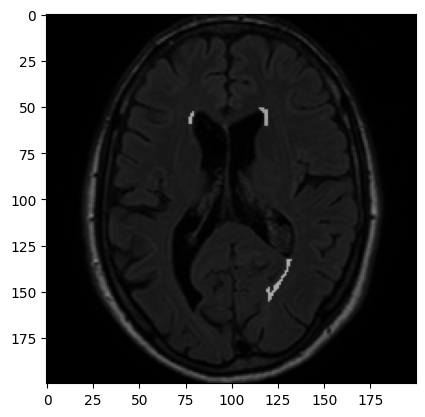

In [45]:
image = np.load('/home/msc2/DATA/Slices/train_normal/utre_006_IMG0023_flair.npy')
mask = np.load('/home/msc2/DATA/Slices/train_normal/utre_006_IMG0023_mask.npy')
print(np.unique(mask))
print(np.min(image), np.max(image))

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.5)

### Amsterdam

In [46]:
amsterdam_path = '/home/msc2/Documents/Data/WMH_Challenge/public/Amsterdam_GE3T/GE3T/'

In [47]:
def GE3T_preprocess(folder_path, 
                    output_path='/home/msc2/DATA/Slices', 
                    naming='amst',
                    range_=(6,6),
                    valid_split=[]
                   ):
    # load the nii files
    start_cut = 46
    full_t1_path    = os.path.join(folder_path, "pre", "T1.nii")
    full_flair_path = os.path.join(folder_path, "pre", "FLAIR.nii")
    full_mask_path  = os.path.join(folder_path, "wmh.nii")
    file_name       = folder_path.split('/')[-1]
    
    # rotate the axial slices such that the eyes face up
    t1    = np.float32(np.rot90(nib.load(full_t1_path).get_fdata(),    k=3))
    flair = np.float32(np.rot90(nib.load(full_flair_path).get_fdata(), k=3))
    mask  = np.rot90(nib.load(full_mask_path).get_fdata(),             k=3)
    
    if len(np.unique(mask)) > 2:
        mask[mask == 2] = 0
    
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows = np.shape(flair)[0]
    cols = np.shape(flair)[1]

    t1_suitable    = np.ndarray((rows_standard, cols_standard, num_selected_slice), dtype=np.float32)
    flair_suitable = np.ndarray((rows_standard, cols_standard, num_selected_slice), dtype=np.float32)
    mask_suitable  =   np.zeros((rows_standard, cols_standard, num_selected_slice), dtype=np.float32)

    # normalize the flair
    t1    -= np.mean(t1)
    t1    /= np.std(t1)
    flair -= np.mean(flair)
    flair /= np.std(flair)
    
    t1_suitable[...]    = np.min(t1)
    flair_suitable[...] = np.min(flair)
    t1_suitable[:, (cols_standard//2 - cols//2):(cols_standard//2 + cols//2), :] =    t1[start_cut:start_cut + rows_standard, :, :]
    flair_suitable[:, (cols_standard//2 - cols//2):(cols_standard//2 + cols//2), :] = flair[start_cut:start_cut + rows_standard, :, :]
    mask_suitable[:, (cols_standard//2 - cols//2):(cols_standard//2 + cols//2), :] =  mask[start_cut:start_cut + rows_standard, :, :]
    mask_suitable   =  mask_suitable[..., np.newaxis]
    t1_suitable     =    t1_suitable[..., np.newaxis]
    flair_suitable  = flair_suitable[..., np.newaxis]
    
    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid_normal')
    else:
        output_path = os.path.join(output_path, 'train_normal')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair_suitable.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        np.save(f'{out_file_path}_t1.npy',       t1_suitable[:,:,i])
        np.save(f'{out_file_path}_flair.npy', flair_suitable[:,:,i])
        np.save(f'{out_file_path}_mask.npy',   mask_suitable[:,:,i])

In [48]:
import random
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(amsterdam_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['137', '126', '107', '108']


In [49]:
for case in tqdm(os.listdir(amsterdam_path), 'Cases : '):
    folder_path = os.path.join(amsterdam_path, case)
    GE3T_preprocess(folder_path, naming='amst', range_=(30,20), valid_split=samples)

Cases : 100%|███████████████████████████████████| 20/20 [00:07<00:00,  2.82it/s]


[0. 1.]
-0.60925543 5.4780035


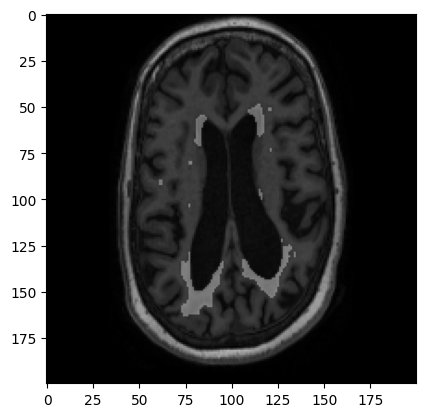

In [50]:
image = np.load('/home/msc2/DATA/Slices/train_normal/amst_132_IMG0051_t1.npy')
mask = np.load('/home/msc2/DATA/Slices/train_normal/amst_132_IMG0051_mask.npy')
print(np.unique(mask))
print(np.min(image), np.max(image))

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='gray',alpha=0.3)

## 2. SSSIHMS Dataset

In [51]:
sssihms_path = '/home/msc2/Documents/Data/WMH-SSSIHMS/'

In [52]:
import nibabel as nib
import os
import numpy as np
from tqdm import tqdm
import random
import albumentations as A

def sssihms_preprocess(folder_path, 
                       output_path='/home/msc2/DATA/Slices', 
                       naming='ihms',
                       range_=(5,5),
                       valid_split=[]
                      ):
    # load the nii files
    full_t1_path    = os.path.join(folder_path, "pre", "T1.nii")
    full_flair_path = os.path.join(folder_path, "pre", "FLAIR.nii")
    full_mask_path  = os.path.join(folder_path, "wmh.nii")
    file_name       = folder_path.split('_')[-1]
    
    resize = A.Resize(220,200)
    
    # rotate the axial slices such that the eyes face up
    t1    = np.rot90(nib.load(full_t1_path).get_fdata(),    k=1)
    flair = np.rot90(nib.load(full_flair_path).get_fdata(), k=1)
    mask  = np.rot90(nib.load(full_mask_path).get_fdata(),  k=1)
        
    t1    =          resize(image=   t1)['image']
    flair =          resize(image=flair)['image']
    mask  = np.round(resize(image= mask)['image'])
        
    # cropping to desired shape
    num_selected_slice = np.shape(flair)[2]
    rows = 220
    cols = 200
    
    flair            =            flair[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    flair -= np.mean(flair)
    flair /=  np.std(flair)
    
    t1            =            t1[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    t1 -= np.mean(t1)
    t1 /=  np.std(t1)

    mask   =  mask[(rows//2 - rows_standard//2):(rows//2 + rows_standard//2), (cols//2 - cols_standard//2):(cols//2 + cols_standard//2), :]
    
    t1     =    t1[..., np.newaxis]
    flair  = flair[..., np.newaxis]
    mask   =  mask[..., np.newaxis]
    
    if file_name in valid_split:
        output_path = os.path.join(output_path, 'valid_normal')
    else:
        output_path = os.path.join(output_path, 'train_normal')
        
    # create directory for output
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    
    # output as npy slices in output folder
    start, end = range_
    for i in range(start, flair.shape[2] - end):
        out_file_path = os.path.join(output_path, f"{naming}_{file_name.zfill(3)}_IMG00{str(i).zfill(2)}")
        if random.randint(0, 1) and mask[:,:,i].sum()==0:
            continue
        np.save(f'{out_file_path}_t1.npy',       t1[:,:,i])
        np.save(f'{out_file_path}_flair.npy', flair[:,:,i])
        np.save(f'{out_file_path}_mask.npy',   mask[:,:,i])

In [53]:
import random
random.seed(48)

cases = [case.split('_')[-1] for case in os.listdir(sssihms_path)]
num_samples = round(0.2 * len(cases))
samples = random.sample(cases, num_samples)
print(samples)

['24', '63', '78', '26', '18', '79', '25', '31', '70', '27', '77', '46', '20', '47', '64']


In [54]:
for case in tqdm(os.listdir(sssihms_path), 'Cases : '):
    folder_path = os.path.join(sssihms_path, case)
    sssihms_preprocess(folder_path, range_=(10,6), valid_split=samples)

Cases : 100%|███████████████████████████████████| 74/74 [00:22<00:00,  3.34it/s]


[0. 1.]
-0.7195909256364306 3.9548184010177674


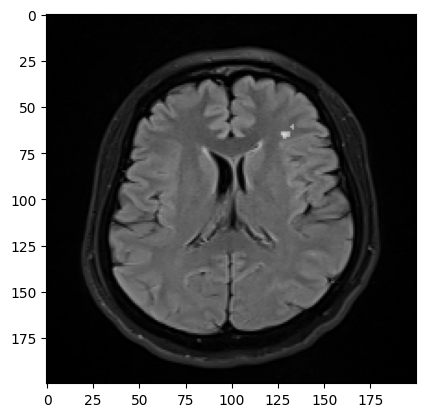

In [63]:
image = np.load('/home/msc2/DATA/Slices/train_normal/ihms_002_IMG0014_flair.npy')
mask = np.load('/home/msc2/DATA/Slices/train_normal/ihms_002_IMG0014_mask.npy')
print(np.unique(mask))
print(np.min(image), np.max(image))

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='gray',alpha=0.3)

## The End